# Optical Music Recognition - PyTorch implementation

In this notebook I train a convolution neural network to be able to correctly identify the pitch of music notes. Currently, the network can only label single notes - but I am aiming to extend it to be able to correctly identify and label notes on an entire page of music.

The dataset I am using was created by Pascal Attwenger, and is available at https://homepage.univie.ac.at/pascal.attwenger/bachelor/.

## 1. Training a single note classifier

In [1002]:
# Import dependencies

import pandas as pd
import cv2
import numpy as np
import os
from tqdm.notebook import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import efficientnet_pytorch
from pathlib import Path
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from random import randrange


from efficientnet_pytorch import EfficientNet

### 1.1 Constructing the data loader and initialising data generators

In [1009]:
class DataSet(torch.utils.data.Dataset):
    
    def __init__(self, fns, root):
        self.file_list = fns  
    
    def __len__(self):
        return len(self.file_list)    
        
    def __getitem__(self, idx):
        
        file_name = self.file_list[idx]
        
        fp = os.path.join(ROOT, file_name)
        img = cv2.imread(fp, cv2.IMREAD_GRAYSCALE)
        img = img / 255.
        
        attr = file_name.split('-')
        type_ = attr[0]
        time = attr[1]
        pitch = attr[2]
        
        return np.expand_dims(img, axis=0).astype('double'), self.map_pitch(pitch)
    
    def map_pitch(self, pitch):

        m = {
            "a": 0,
             "h": 1,
             "c1": 2,
             "d1": 3,
             "e1": 4,
             "f1": 5,
             "g1": 6,
             "a1": 0,
             "h1": 1,
             "c2": 2,
             "d2": 3,
             "e2": 4,
             "f2": 5,
             "g2": 6,
             "a2": 0,
             "h2": 1,
             "c3": 2,
             "other": 7
            }

        return m[pitch]
    
    
    
params = {'batch_size': 16, 'shuffle': True, 'num_workers': 0}

ROOT = 'data/originals-resized/'

all_ims = [file for file in os.listdir(ROOT) \
                          if os.path.isfile(ROOT + file) \
                          and file[0:4] == 'note']


train_fns, test_fns = train_test_split(all_ims, test_size = 0.15)
train_fns, val_fns = train_test_split(train_fns, test_size = 0.15)



train_set  = DataSet(train_fns, ROOT)
train_generator = torch.utils.data.DataLoader(train_set, **params)

val_set = DataSet(val_fns, ROOT)
val_generator = torch.utils.data.DataLoader(val_set, **params)


test_set = DataSet(test_fns, ROOT)
test_generator = torch.utils.data.DataLoader(test_set)

### 1.2 Visualising a few images from the dataset

In [1010]:
train_set.__len__()

2354

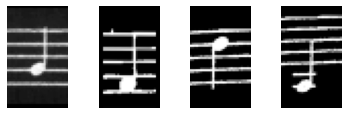

In [1011]:
# Lets take a look at what a subset of our images look like
idxs = [randrange(train_set.__len__()) for i in range(4)]

for i, idx in enumerate(idxs):
    plt.subplot(1, 4, i + 1)
    plt.axis('off')
    plt.imshow(train_set.__getitem__(idx)[0].squeeze(), cmap = 'Greys')
    plt.subplots_adjust(wspace = 0.5)

### 1.3 Constructing the network

In [1012]:
class ConvNetSingle(nn.Module):
    
    def __init__(self):
        super(ConvNetSingle, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels = 1, kernel_size = 5, out_channels = 3)
        nn.init.xavier_normal_(self.conv1.weight)
        self.conv2 = nn.Conv2d(in_channels = 3, kernel_size = 3, out_channels = 3)
        nn.init.xavier_normal_(self.conv2.weight)
        self.pool1 = nn.MaxPool2d(2)
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(792, 256)
        nn.init.xavier_normal_(self.fc1.weight)
        self.fc2 = nn.Linear(256, 8)
        nn.init.xavier_normal_(self.fc2.weight)
        self.fc3 = nn.Linear(16, 8)
        nn.init.xavier_normal_(self.fc3.weight)
        
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        output = F.log_softmax(x, dim=1)
        return output

### 1.3 Training the network

In [1015]:
model = ConvNetSingle()
optimiser = optim.Adam(model.parameters(), lr=0.001)
max_epochs = 10
log_int = 1

# Now for the training loop
for epoch in tqdm(range(max_epochs)):
    correct = 0
    total = 0
    correct_val = 0
    total_val = 0
    for local_batch, local_labels in train_generator:
        optimiser.zero_grad()
        pred = model(local_batch.float())
        loss = F.nll_loss(pred, local_labels)
        _, predicted = torch.max(pred.data, 1)
                
        total += local_labels.size(0)
        correct += (predicted == local_labels).sum().item()
        loss.backward()
        optimiser.step()
        
    with torch.no_grad():
            for local_batch, local_labels in val_generator:
                        optimiser.zero_grad()
                        pred = model(local_batch.float())
                        loss = F.nll_loss(pred, local_labels)
                        _, predicted = torch.max(pred.data, 1)
                        optimiser.step()
                        total_val += local_labels.size(0)
                        correct_val += (predicted == local_labels).sum().item()
    
    if (epoch % log_int) == 0:
        print(f'Epoch {epoch + 1} / {max_epochs}')
        print(f'Training accuracy = {round(correct/total, 4)}    Validation accuracy = {round(correct_val/total_val, 4)} \n')

Epoch 1 / 10
Training accuracy = 0.4588    Validation accuracy = 0.4615 

Epoch 2 / 10
Training accuracy = 0.6818    Validation accuracy = 0.5 

Epoch 3 / 10
Training accuracy = 0.7948    Validation accuracy = 0.7548 

Epoch 4 / 10
Training accuracy = 0.8832    Validation accuracy = 0.7308 

Epoch 5 / 10
Training accuracy = 0.9282    Validation accuracy = 0.7236 

Epoch 6 / 10
Training accuracy = 0.9592    Validation accuracy = 0.7933 

Epoch 7 / 10
Training accuracy = 0.9881    Validation accuracy = 0.8053 

Epoch 8 / 10
Training accuracy = 0.9885    Validation accuracy = 0.8173 

Epoch 9 / 10
Training accuracy = 0.9953    Validation accuracy = 0.8269 

Epoch 10 / 10
Training accuracy = 1.0    Validation accuracy = 0.8293 




### 1.4 Testing the network

In [1018]:
# Test loop
total = 0
correct = 0
with torch.no_grad():
    model.eval()
    for ims, labs in test_generator:
        outputs = model(ims.float())
        _, predicted = torch.max(outputs.data, 1)
        total += labs.size(0)
        correct += (predicted == labs).sum().item()

print('Accuracy on test images: %d %%' % (100 * correct / total))

Accuracy on test images: 80 %


## 2.  Object detection and bounding box cropping

## 3.  Putting the pieces together